### Libraries


In [ ]:
# %pip install optuna
# %pip install torch

In [ ]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

try:
    import optuna
except Exception as e:
    raise ImportError("Optuna not found.") from e

try:
    from torchvision import transforms
    HAS_TORCHVISION = True
except Exception:
    HAS_TORCHVISION = False

### Config


In [ ]:
CFG = {
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 2 if torch.cuda.is_available() else 0,
    "pin_memory": True if torch.cuda.is_available() else False,

    # Tuning
    "n_trials": 25,
    "timeout_sec": None,
    "tune_val_size": 0.12,

    # Final CV
    "n_folds": 5,
}
print("Device:", CFG["device"])

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True  # set False for strict determinism

set_seed(CFG["seed"])

Device: cuda


### Import Data


In [ ]:
# Path
DATA_DIR = Path("/content/data")

train_df = pd.read_csv(DATA_DIR / "train.csv")
test_df  = pd.read_csv(DATA_DIR / "test.csv")
sub_df   = pd.read_csv(DATA_DIR / "sample_submission.csv")

train_df.shape, test_df.shape, sub_df.shape

((42000, 785), (28000, 784), (28000, 2))

### Data Cleaning & Preprocessing


In [ ]:
y = train_df["label"].to_numpy(np.int64)
X = train_df.drop(columns=["label"]).to_numpy(np.uint8)

X_test = test_df.to_numpy(np.uint8)

# reshape to NCHW
X = X.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

# compute mean/std using TRAIN
X_f = X.astype(np.float32) / 255.0
PIX_MEAN = float(X_f.mean())
PIX_STD  = float(X_f.std() + 1e-7)

PIX_MEAN, PIX_STD

(0.13101521134376526, 0.30853891372680664)

### EDA


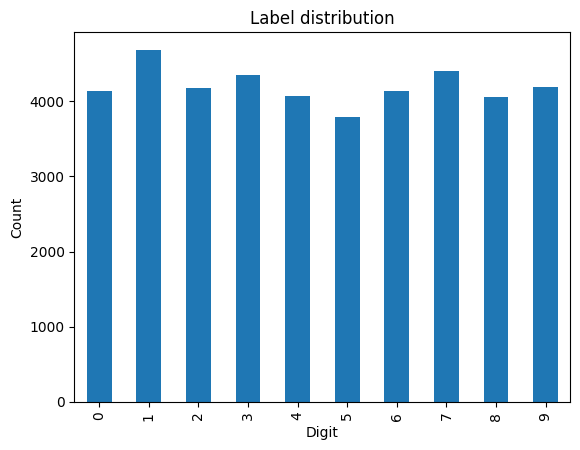

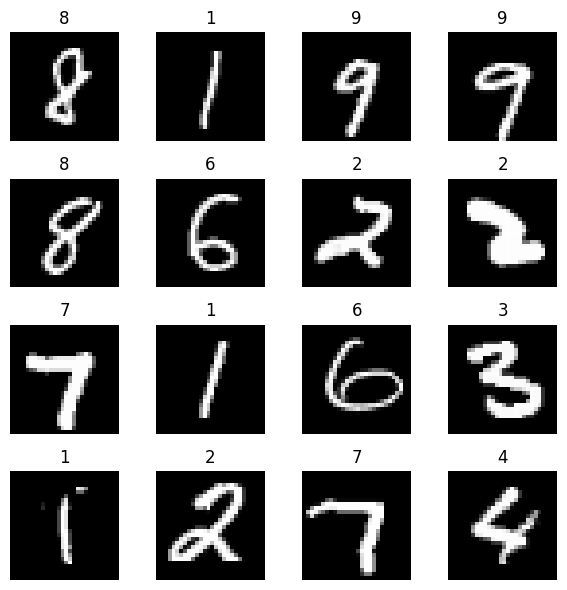

In [39]:
# label distribution
counts = pd.Series(y).value_counts().sort_index()
plt.figure()
counts.plot(kind="bar")
plt.title("Label distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()
print()

# show a few samples
idx = np.random.choice(len(X), size=16, replace=False)
plt.figure(figsize=(6, 6))
for i, j in enumerate(idx, 1):
    plt.subplot(4, 4, i)
    plt.imshow(X[j, 0], cmap="gray")
    plt.title(str(y[j]))
    plt.axis("off")
plt.tight_layout()
plt.show()

### Feature Engineering & Selection


In [40]:
def make_augmenter(trial=None):
    if not HAS_TORCHVISION:
        return None

    # Fixed "sane default" augmentation; optionally tuned a bit
    if trial is None:
        degrees = 10
        translate = (0.10, 0.10)
        scale = (0.90, 1.10)
    else:
        degrees = trial.suggest_int("aug_degrees", 0, 12)
        t = trial.suggest_float("aug_translate", 0.0, 0.12)
        s_lo = trial.suggest_float("aug_scale_lo", 0.88, 1.0)
        s_hi = trial.suggest_float("aug_scale_hi", 1.0, 1.12)
        translate = (t, t)
        scale = (s_lo, s_hi)

    return transforms.RandomAffine(
        degrees=degrees,
        translate=translate,
        scale=scale
    )

### Model Training (CNN)


In [41]:
class CNNNet(nn.Module):
    def __init__(self, base_ch=32, n_blocks=3, dropout=0.2, head_dim=256):
        super().__init__()
        ch = base_ch
        layers = []
        in_ch = 1

        for _ in range(n_blocks):
            layers += [
                nn.Conv2d(in_ch, ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(ch, ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(dropout),
            ]
            in_ch = ch
            ch *= 2

        self.backbone = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_ch, head_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(head_dim, 10),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.head(x)
        return x

In [42]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    n = 0
    correct = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True).float() / 255.0
        xb = (xb - PIX_MEAN) / PIX_STD
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = F.cross_entropy(logits, yb, reduction="sum")

        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()

        total_loss += loss.item()
        n += yb.size(0)

    return total_loss / n, correct / n


def train_one_epoch(model, loader, optimizer, device, aug=None, label_smoothing=0.0, grad_clip=1.0):
    model.train()
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))

    total_loss = 0.0
    n = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True).float() / 255.0
        if aug is not None:
            xb = aug(xb)
        xb = (xb - PIX_MEAN) / PIX_STD

        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda', enabled=(device == "cuda")):
            logits = model(xb)
            loss = F.cross_entropy(logits, yb, label_smoothing=label_smoothing)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * yb.size(0)
        n += yb.size(0)

    return total_loss / n

### Hyperparameter Tuning (Optuna)


In [ ]:
def objective(trial):
    set_seed(CFG["seed"])

    # search space
    base_ch = trial.suggest_categorical("base_ch", [24, 32, 40, 48])
    n_blocks = trial.suggest_int("n_blocks", 2, 3)
    dropout = trial.suggest_float("dropout", 0.10, 0.45)
    head_dim = trial.suggest_categorical("head_dim", [128, 192, 256, 384])
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 96, 128, 192, 256])
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.08)
    epochs = trial.suggest_int("epochs", 8, 16)

    aug = make_augmenter(trial)

    # stratified single split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=CFG["tune_val_size"], random_state=CFG["seed"])
    tr_idx, va_idx = next(sss.split(X, y))

    X_tr = torch.from_numpy(X[tr_idx])
    y_tr = torch.from_numpy(y[tr_idx])
    X_va = torch.from_numpy(X[va_idx])
    y_va = torch.from_numpy(y[va_idx])

    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr),
        batch_size=batch_size,
        shuffle=True,
        num_workers=CFG["num_workers"],
        pin_memory=CFG["pin_memory"],
        drop_last=True,
    )
    val_loader = DataLoader(
        TensorDataset(X_va, y_va),
        batch_size=512,
        shuffle=False,
        num_workers=CFG["num_workers"],
        pin_memory=CFG["pin_memory"],
    )

    device = CFG["device"]
    model = CNNNet(base_ch=base_ch, n_blocks=n_blocks, dropout=dropout, head_dim=head_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0.0
    patience = 3
    bad = 0

    for ep in range(epochs):
        train_one_epoch(model, train_loader, optimizer, device, aug=aug, label_smoothing=label_smoothing)
        _, acc = evaluate(model, val_loader, device)
        scheduler.step()

        trial.report(acc, step=ep)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if acc > best_acc:
            best_acc = acc
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    return best_acc


pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2, interval_steps=1)
sampler = optuna.samplers.TPESampler(seed=CFG["seed"])

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=CFG["n_trials"], show_progress_bar=True, timeout=CFG["timeout_sec"])

print("Best value:", study.best_value)
print("Best params:", study.best_params)

[I 2026-02-03 17:25:49,552] A new study created in memory with name: no-name-577ec7e7-d6bf-4b4e-a408-03015ce42c07


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-03 17:26:46,148] Trial 0 finished with value: 0.9777777777777777 and parameters: {'base_ch': 32, 'n_blocks': 2, 'dropout': 0.15459808211767093, 'head_dim': 192, 'lr': 0.00010725209743172001, 'weight_decay': 0.00757947995334801, 'batch_size': 64, 'label_smoothing': 0.04198051453057903, 'epochs': 11, 'aug_degrees': 3, 'aug_translate': 0.07342234736668553, 'aug_scale_lo': 0.896739263278245, 'aug_scale_hi': 1.0350573578242261}. Best is trial 0 with value: 0.9777777777777777.
[I 2026-02-03 17:28:01,417] Trial 1 finished with value: 0.9964285714285714 and parameters: {'base_ch': 40, 'n_blocks': 3, 'dropout': 0.30734509910171487, 'head_dim': 192, 'lr': 0.00252126790477792, 'weight_decay': 0.007286653737491046, 'batch_size': 64, 'label_smoothing': 0.009763058787582306, 'epochs': 12, 'aug_degrees': 0, 'aug_translate': 0.10911844824945384, 'aug_scale_lo': 0.911053597792002, 'aug_scale_hi': 1.079502674122478}. Best is trial 1 with value: 0.9964285714285714.
[I 2026-02-03 17:28:34,536] 

In [44]:
# Quick view of top trials
df_trials = study.trials_dataframe().sort_values("value", ascending=False)
df_trials.head(10)

,number,value,datetime_start,datetime_complete,duration,params_aug_degrees,params_aug_scale_hi,params_aug_scale_lo,params_aug_translate,params_base_ch,params_batch_size,params_dropout,params_epochs,params_head_dim,params_label_smoothing,params_lr,params_n_blocks,params_weight_decay,state
21,21,0.996825,2026-02-03 17:38:56.850933,2026-02-03 17:39:44.758903,0 days 00:00:47.907970,2,1.049167,0.913218,0.119157,40,128,0.318233,13,192,0.067869,0.001821,3,0.000979,COMPLETE
18,18,0.996627,2026-02-03 17:37:27.995215,2026-02-03 17:38:15.529757,0 days 00:00:47.534542,3,1.038656,0.931555,0.066711,40,128,0.255532,11,192,0.079157,0.000810,3,0.000409,COMPLETE
24,24,0.996627,2026-02-03 17:40:18.519409,2026-02-03 17:41:14.001795,0 days 00:00:55.482386,4,1.045287,0.934862,0.024879,40,128,0.234292,15,192,0.079293,0.000511,3,0.000136,COMPLETE
5,5,0.996627,2026-02-03 17:30:53.176676,2026-02-03 17:32:06.806864,0 days 00:01:13.630188,12,1.084362,0.942255,0.038784,48,64,0.382604,11,128,0.009589,0.000427,3,0.001871,COMPLETE
1,1,0.996429,2026-02-03 17:26:46.152664,2026-02-03 17:28:01.417540,0 days 00:01:15.264876,0,1.079503,0.911054,0.109118,40,64,0.307345,12,192,0.009763,0.002521,3,0.007287,COMPLETE
15,15,0.996429,2026-02-03 17:35:33.911265,2026-02-03 17:36:44.836743,0 days 00:01:10.925478,6,1.115131,0.955051,0.093281,48,64,0.288745,12,128,0.033082,0.001613,3,0.009964,COMPLETE
8,8,0.996230,2026-02-03 17:32:38.838603,2026-02-03 17:33:23.807799,0 days 00:00:44.969196,11,1.012177,0.881104,0.072771,40,96,0.184648,9,256,0.006731,0.000317,3,0.000025,COMPLETE
4,4,0.996032,2026-02-03 17:29:56.217489,2026-02-03 17:30:53.171962,0 days 00:00:56.954473,2,1.076008,0.976974,0.111564,40,64,0.249639,10,384,0.006158,0.000291,3,0.000108,COMPLETE
19,19,0.994444,2026-02-03 17:38:15.533651,2026-02-03 17:38:47.528909,0 days 00:00:31.995258,3,1.034036,0.934669,0.063373,48,128,0.254080,11,128,0.076587,0.000773,3,0.000294,PRUNED
12,12,0.993849,2026-02-03 17:34:15.332028,2026-02-03 17:35:03.745912,0 days 00:00:48.413884,0,1.092108,0.926592,0.091404,48,96,0.293086,14,128,0.028253,0.002994,3,0.007657,PRUNED


### Cross Validation, Testing & Evaluation


In [45]:
best = study.best_params

def run_cv(params, n_folds=5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=CFG["seed"])
    oof_acc = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr = torch.from_numpy(X[tr_idx])
        y_tr = torch.from_numpy(y[tr_idx])
        X_va = torch.from_numpy(X[va_idx])
        y_va = torch.from_numpy(y[va_idx])

        train_loader = DataLoader(
            TensorDataset(X_tr, y_tr),
            batch_size=params["batch_size"],
            shuffle=True,
            num_workers=CFG["num_workers"],
            pin_memory=CFG["pin_memory"],
            drop_last=True,
        )
        val_loader = DataLoader(
            TensorDataset(X_va, y_va),
            batch_size=512,
            shuffle=False,
            num_workers=CFG["num_workers"],
            pin_memory=CFG["pin_memory"],
        )

        device = CFG["device"]
        model = CNNNet(
            base_ch=params["base_ch"],
            n_blocks=params["n_blocks"],
            dropout=params["dropout"],
            head_dim=params["head_dim"],
        ).to(device)

        aug = make_augmenter(None)  # fixed default augmentation for CV
        optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params["epochs"])

        best_acc = 0.0
        bad = 0
        patience = 4

        for ep in range(params["epochs"]):
            train_one_epoch(
                model, train_loader, optimizer, device,
                aug=aug,
                label_smoothing=params["label_smoothing"]
            )
            _, acc = evaluate(model, val_loader, device)
            scheduler.step()

            if acc > best_acc:
                best_acc = acc
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    break

        oof_acc.append(best_acc)
        print(f"Fold {fold}: best val acc = {best_acc:.5f}")

    print(f"\nCV mean acc = {np.mean(oof_acc):.5f} ± {np.std(oof_acc):.5f}")
    return oof_acc

cv_scores = run_cv(best, n_folds=CFG["n_folds"])

Fold 1: best val acc = 0.99536
Fold 2: best val acc = 0.99524
Fold 3: best val acc = 0.99560
Fold 4: best val acc = 0.99607
Fold 5: best val acc = 0.99536

CV mean acc = 0.99552 ± 0.00030


In [46]:
device = CFG["device"]
params = best

X_tr_full = torch.from_numpy(X)
y_tr_full = torch.from_numpy(y)
X_test_t  = torch.from_numpy(X_test)

train_loader = DataLoader(
    TensorDataset(X_tr_full, y_tr_full),
    batch_size=params["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=CFG["pin_memory"],
    drop_last=True,
)

test_loader = DataLoader(
    TensorDataset(X_test_t, torch.zeros(len(X_test_t), dtype=torch.long)),
    batch_size=512,
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=CFG["pin_memory"],
)

model = CNNNet(
    base_ch=params["base_ch"],
    n_blocks=params["n_blocks"],
    dropout=params["dropout"],
    head_dim=params["head_dim"],
).to(device)

aug = make_augmenter(None)
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params["epochs"])

for ep in range(params["epochs"]):
    loss = train_one_epoch(
        model, train_loader, optimizer, device,
        aug=aug,
        label_smoothing=params["label_smoothing"]
    )
    scheduler.step()
    print(f"Epoch {ep+1}/{params['epochs']} - loss: {loss:.4f}")

@torch.no_grad()
def predict(model, loader, device):
    model.eval()
    preds = []
    for xb, _ in loader:
        xb = xb.to(device, non_blocking=True).float() / 255.0
        xb = (xb - PIX_MEAN) / PIX_STD
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
    return np.concatenate(preds)

test_pred = predict(model, test_loader, device)

submission = pd.DataFrame({"ImageId": np.arange(1, len(test_pred) + 1), "Label": test_pred})
submission.to_csv("submission.csv", index=False)
submission.head()

Epoch 1/13 - loss: 0.6745
Epoch 2/13 - loss: 0.4676
Epoch 3/13 - loss: 0.4440
Epoch 4/13 - loss: 0.4342
Epoch 5/13 - loss: 0.4242
Epoch 6/13 - loss: 0.4189
Epoch 7/13 - loss: 0.4149
Epoch 8/13 - loss: 0.4106
Epoch 9/13 - loss: 0.4080
Epoch 10/13 - loss: 0.4045
Epoch 11/13 - loss: 0.4011
Epoch 12/13 - loss: 0.4005
Epoch 13/13 - loss: 0.3988


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
